# Face Generation

In this project, you'll use generative adversarial networks to generate new images of faces.    

### Get the Data

You'll be using two datasets in this project:    
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.    

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".    

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`.     

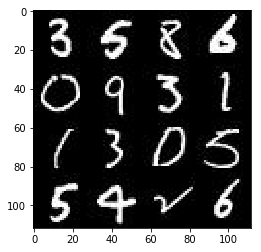

In [2]:
show_n_images = 21

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.


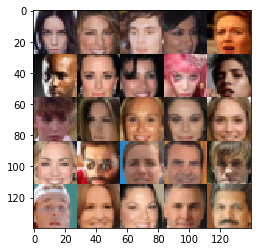

In [3]:
show_n_images = 30

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data

Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.    

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).        

## Build the Neural Network

You'll build the components necessary to build a GANs by implementing the following functions below:    

- `model_inputs`  
- `discriminator` 
- `generator` 
- `model_loss` 
- `model_opt`  
- `train`   

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU    

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:

- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_ph = tf.placeholder(shape = [None, image_width, image_height, image_channels], dtype=tf.float32)
    z_ph = tf.placeholder(shape = [None, z_dim], dtype=tf.float32)
    lr_ph = tf.placeholder(dtype=tf.float32)
    return input_ph, z_ph, lr_ph

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator

Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).


In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("discriminator", reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        x1 = tf.layers.dropout(relu1, rate=0.6)
        
        conv2 = tf.layers.conv2d(x1, 128, 5, strides = 2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        x2 = tf.layers.dropout(relu2, rate=0.6)
        
        conv3 = tf.layers.conv2d(x2, 256, 5, strides = 2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        x3 = tf.layers.dropout(relu3, rate=0.6)
        
        flatten = tf.reshape(x3, (-1, 4*4*128))

        logits = tf.layers.dense(flatten, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator    

Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # Dense1 / Reshape
        h1 = tf.layers.dense(z, 7*7*512, activation=None)
        h1 = tf.reshape(h1, (-1, 7, 7, 512))    # Reshape
        bn1 = tf.layers.batch_normalization(h1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        x1 = tf.layers.dropout(relu1, rate=0.6)
        
        # conv2
        conv2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2,kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same', activation=None)
        bn2 = tf.layers.batch_normalization(conv2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        x2 = tf.layers.dropout(relu2, rate=0.6)
        
        # conv3
        conv3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same', activation=None)
        bn3 = tf.layers.batch_normalization(conv3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        x3 = tf.layers.dropout(relu3, rate=0.6)
        
        # conv4 
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2,kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same', activation=None)
        out = tf.tanh(logits)    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`


In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Build network
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels= 0.9 * tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                              labels=tf.ones_like(d_logits_fake)))      
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train

Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.  

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, width, height, channel = data_shape
    
    input_, z_, lr_ = model_inputs(width, height, channel, z_dim)
    d_loss, g_loss = model_loss(input_, z_, channel)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_, beta1)

    steps = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_train_opt, feed_dict={input_: batch_images, z_: batch_z, lr_:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_: batch_images, z_: batch_z, lr_:learning_rate})

                if steps % 20 == 0:
                    train_loss_d = d_loss.eval({z_: batch_z, input_: batch_images})
                    train_loss_g = g_loss.eval({z_: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % batch_size == 0:
                    show_generator_output(sess, 25, z_, channel, data_image_mode)               

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.


Epoch 1/2... Discriminator Loss: 0.6752... Generator Loss: 3.4540
Epoch 1/2... Discriminator Loss: 1.5961... Generator Loss: 0.5391
Epoch 1/2... Discriminator Loss: 1.3648... Generator Loss: 0.7575


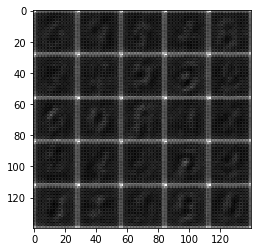

Epoch 1/2... Discriminator Loss: 1.1635... Generator Loss: 0.8810
Epoch 1/2... Discriminator Loss: 1.2203... Generator Loss: 1.0362
Epoch 1/2... Discriminator Loss: 1.5953... Generator Loss: 0.4344


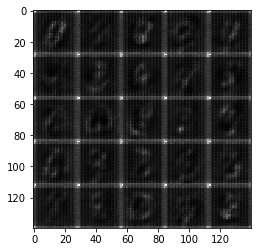

Epoch 1/2... Discriminator Loss: 1.0022... Generator Loss: 1.1105
Epoch 1/2... Discriminator Loss: 1.4433... Generator Loss: 2.3366
Epoch 1/2... Discriminator Loss: 1.0974... Generator Loss: 1.5889


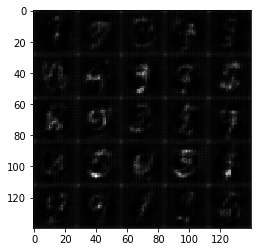

Epoch 1/2... Discriminator Loss: 1.1765... Generator Loss: 2.0165
Epoch 1/2... Discriminator Loss: 1.0291... Generator Loss: 1.3968
Epoch 1/2... Discriminator Loss: 1.0224... Generator Loss: 0.9469


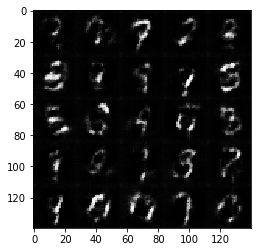

Epoch 1/2... Discriminator Loss: 0.9699... Generator Loss: 1.3943
Epoch 1/2... Discriminator Loss: 1.1029... Generator Loss: 0.7545
Epoch 1/2... Discriminator Loss: 1.1285... Generator Loss: 0.7947
Epoch 1/2... Discriminator Loss: 1.0949... Generator Loss: 1.3972


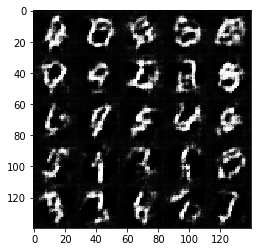

Epoch 1/2... Discriminator Loss: 1.2404... Generator Loss: 0.6484
Epoch 1/2... Discriminator Loss: 1.2290... Generator Loss: 0.6744
Epoch 1/2... Discriminator Loss: 1.0520... Generator Loss: 0.9936


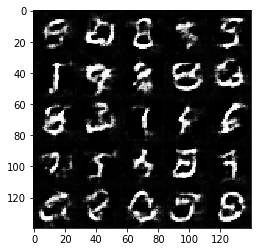

Epoch 1/2... Discriminator Loss: 1.2486... Generator Loss: 0.5984
Epoch 1/2... Discriminator Loss: 1.0705... Generator Loss: 0.8985
Epoch 1/2... Discriminator Loss: 1.2772... Generator Loss: 0.6103


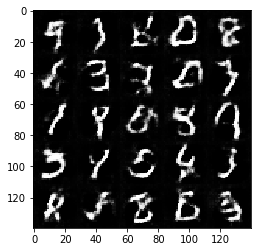

Epoch 1/2... Discriminator Loss: 1.1117... Generator Loss: 0.8834
Epoch 1/2... Discriminator Loss: 1.0414... Generator Loss: 0.9460
Epoch 1/2... Discriminator Loss: 1.2656... Generator Loss: 0.6866


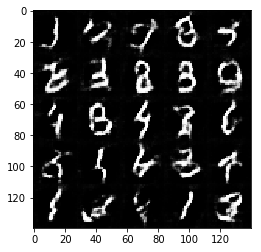

Epoch 1/2... Discriminator Loss: 1.1941... Generator Loss: 0.7090
Epoch 1/2... Discriminator Loss: 1.0905... Generator Loss: 1.1956
Epoch 1/2... Discriminator Loss: 1.3350... Generator Loss: 0.5549


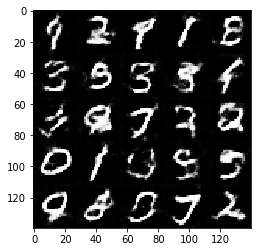

Epoch 1/2... Discriminator Loss: 1.2759... Generator Loss: 0.5990
Epoch 1/2... Discriminator Loss: 1.1335... Generator Loss: 0.8671
Epoch 1/2... Discriminator Loss: 1.1295... Generator Loss: 1.0231
Epoch 1/2... Discriminator Loss: 1.1787... Generator Loss: 0.7664


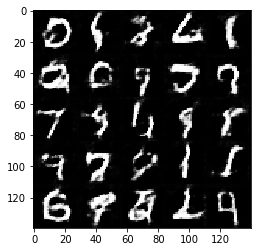

Epoch 1/2... Discriminator Loss: 1.0859... Generator Loss: 1.0985
Epoch 1/2... Discriminator Loss: 1.0579... Generator Loss: 1.0971
Epoch 1/2... Discriminator Loss: 1.1483... Generator Loss: 1.4166


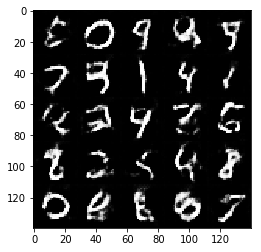

Epoch 1/2... Discriminator Loss: 1.2215... Generator Loss: 0.7899
Epoch 1/2... Discriminator Loss: 1.1869... Generator Loss: 1.1312
Epoch 1/2... Discriminator Loss: 1.1907... Generator Loss: 0.7380


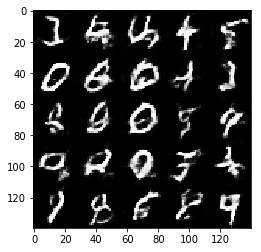

Epoch 1/2... Discriminator Loss: 1.1004... Generator Loss: 0.8386
Epoch 1/2... Discriminator Loss: 1.1465... Generator Loss: 0.7298
Epoch 1/2... Discriminator Loss: 1.0508... Generator Loss: 0.9827


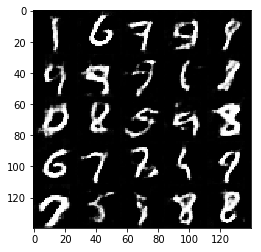

Epoch 1/2... Discriminator Loss: 1.1233... Generator Loss: 0.8104
Epoch 1/2... Discriminator Loss: 1.2028... Generator Loss: 1.4841
Epoch 1/2... Discriminator Loss: 1.2454... Generator Loss: 0.7255


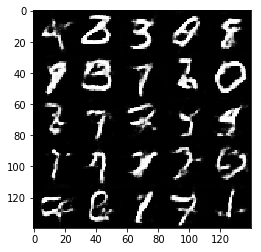

Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 1.0730
Epoch 1/2... Discriminator Loss: 1.8132... Generator Loss: 2.6690
Epoch 2/2... Discriminator Loss: 1.0994... Generator Loss: 0.9852
Epoch 2/2... Discriminator Loss: 1.2186... Generator Loss: 1.0633


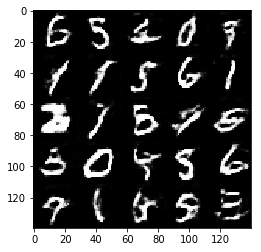

Epoch 2/2... Discriminator Loss: 1.0965... Generator Loss: 1.1343
Epoch 2/2... Discriminator Loss: 1.1483... Generator Loss: 0.7991
Epoch 2/2... Discriminator Loss: 1.1217... Generator Loss: 0.8691


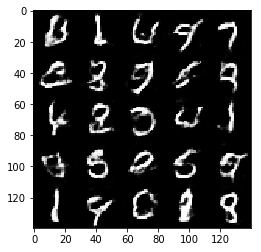

Epoch 2/2... Discriminator Loss: 1.2138... Generator Loss: 0.6213
Epoch 2/2... Discriminator Loss: 2.0862... Generator Loss: 2.7214
Epoch 2/2... Discriminator Loss: 1.1344... Generator Loss: 1.2588


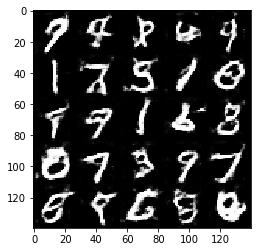

Epoch 2/2... Discriminator Loss: 0.9809... Generator Loss: 1.2338
Epoch 2/2... Discriminator Loss: 1.4133... Generator Loss: 2.2360
Epoch 2/2... Discriminator Loss: 1.1270... Generator Loss: 0.7284


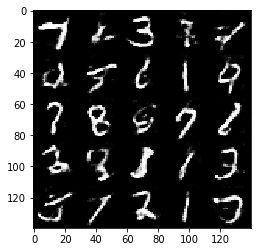

Epoch 2/2... Discriminator Loss: 1.2195... Generator Loss: 1.9572
Epoch 2/2... Discriminator Loss: 0.9875... Generator Loss: 1.0789
Epoch 2/2... Discriminator Loss: 1.0687... Generator Loss: 1.8865


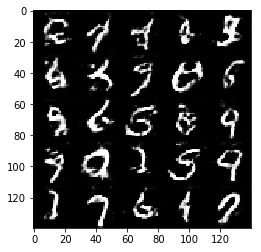

Epoch 2/2... Discriminator Loss: 1.5863... Generator Loss: 0.4050
Epoch 2/2... Discriminator Loss: 1.0426... Generator Loss: 0.9622
Epoch 2/2... Discriminator Loss: 1.3330... Generator Loss: 0.5419
Epoch 2/2... Discriminator Loss: 1.5271... Generator Loss: 2.0023


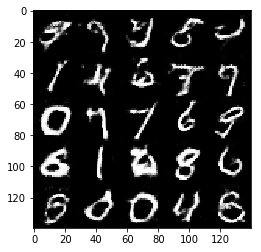

Epoch 2/2... Discriminator Loss: 1.2745... Generator Loss: 0.6483
Epoch 2/2... Discriminator Loss: 1.2885... Generator Loss: 0.6186
Epoch 2/2... Discriminator Loss: 2.2242... Generator Loss: 0.2045


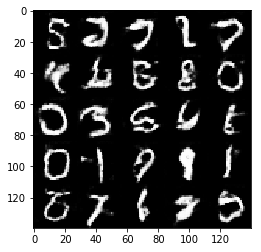

Epoch 2/2... Discriminator Loss: 0.9410... Generator Loss: 1.0670
Epoch 2/2... Discriminator Loss: 1.1160... Generator Loss: 0.8132
Epoch 2/2... Discriminator Loss: 1.1210... Generator Loss: 0.9013


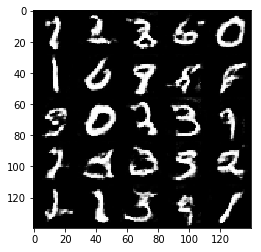

Epoch 2/2... Discriminator Loss: 0.9995... Generator Loss: 0.9152
Epoch 2/2... Discriminator Loss: 1.1755... Generator Loss: 0.9604
Epoch 2/2... Discriminator Loss: 1.0496... Generator Loss: 1.3554


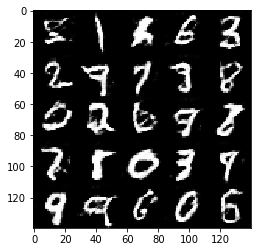

Epoch 2/2... Discriminator Loss: 1.1884... Generator Loss: 0.6875
Epoch 2/2... Discriminator Loss: 0.8996... Generator Loss: 1.2063
Epoch 2/2... Discriminator Loss: 2.2994... Generator Loss: 3.2948


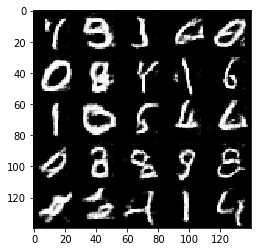

Epoch 2/2... Discriminator Loss: 1.0923... Generator Loss: 0.8559
Epoch 2/2... Discriminator Loss: 0.9917... Generator Loss: 1.4499
Epoch 2/2... Discriminator Loss: 0.9628... Generator Loss: 0.9469
Epoch 2/2... Discriminator Loss: 0.8334... Generator Loss: 1.2212


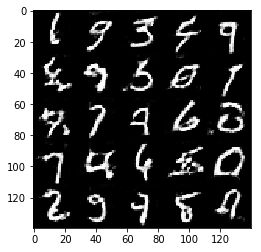

Epoch 2/2... Discriminator Loss: 0.8778... Generator Loss: 1.5748
Epoch 2/2... Discriminator Loss: 1.3185... Generator Loss: 0.6087
Epoch 2/2... Discriminator Loss: 0.9274... Generator Loss: 1.0860


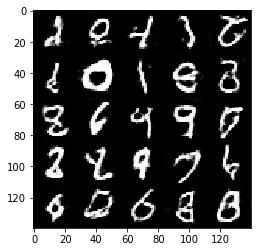

Epoch 2/2... Discriminator Loss: 1.2822... Generator Loss: 0.5864
Epoch 2/2... Discriminator Loss: 0.8749... Generator Loss: 1.3448
Epoch 2/2... Discriminator Loss: 0.8744... Generator Loss: 1.2213


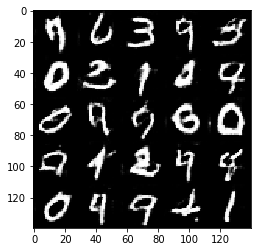

Epoch 2/2... Discriminator Loss: 1.2998... Generator Loss: 0.5781
Epoch 2/2... Discriminator Loss: 0.8975... Generator Loss: 1.2729
Epoch 2/2... Discriminator Loss: 1.2695... Generator Loss: 0.6539


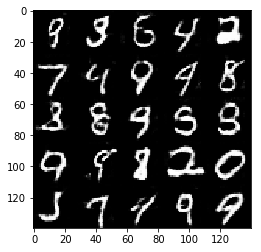

Epoch 2/2... Discriminator Loss: 1.1425... Generator Loss: 0.8031
Epoch 2/2... Discriminator Loss: 0.8671... Generator Loss: 1.3326
Epoch 2/2... Discriminator Loss: 1.3008... Generator Loss: 0.5731


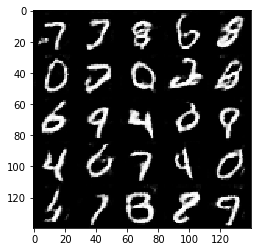

Epoch 2/2... Discriminator Loss: 1.2398... Generator Loss: 0.6454


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 0.9195... Generator Loss: 1.4074
Epoch 1/2... Discriminator Loss: 1.8755... Generator Loss: 1.5548
Epoch 1/2... Discriminator Loss: 1.2642... Generator Loss: 1.1667


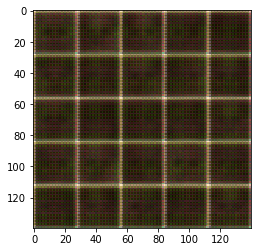

Epoch 1/2... Discriminator Loss: 1.6238... Generator Loss: 0.6603
Epoch 1/2... Discriminator Loss: 1.3821... Generator Loss: 0.9012
Epoch 1/2... Discriminator Loss: 1.2888... Generator Loss: 0.6964


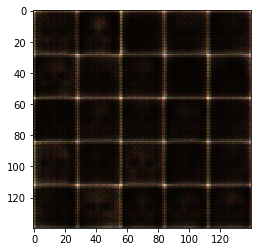

Epoch 1/2... Discriminator Loss: 1.1811... Generator Loss: 1.0754
Epoch 1/2... Discriminator Loss: 1.3471... Generator Loss: 0.8181
Epoch 1/2... Discriminator Loss: 1.4948... Generator Loss: 0.8089


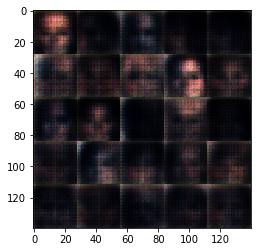

Epoch 1/2... Discriminator Loss: 1.4782... Generator Loss: 0.8023
Epoch 1/2... Discriminator Loss: 1.4675... Generator Loss: 0.7825
Epoch 1/2... Discriminator Loss: 1.2755... Generator Loss: 1.2111


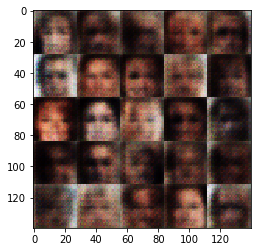

Epoch 1/2... Discriminator Loss: 1.1183... Generator Loss: 1.0464
Epoch 1/2... Discriminator Loss: 1.1417... Generator Loss: 0.9509
Epoch 1/2... Discriminator Loss: 1.2079... Generator Loss: 1.6801
Epoch 1/2... Discriminator Loss: 1.1870... Generator Loss: 1.2724


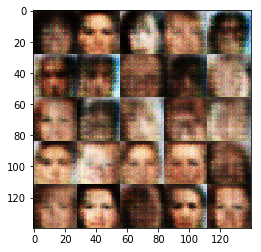

Epoch 1/2... Discriminator Loss: 1.2091... Generator Loss: 1.3935
Epoch 1/2... Discriminator Loss: 1.3580... Generator Loss: 0.7566
Epoch 1/2... Discriminator Loss: 1.3898... Generator Loss: 0.8929


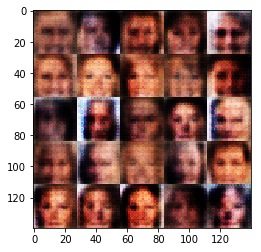

Epoch 1/2... Discriminator Loss: 1.2766... Generator Loss: 0.8810
Epoch 1/2... Discriminator Loss: 1.4053... Generator Loss: 0.7990
Epoch 1/2... Discriminator Loss: 1.5094... Generator Loss: 0.6107


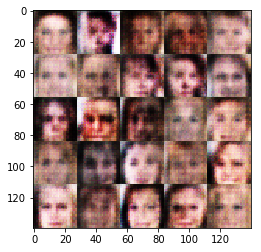

Epoch 1/2... Discriminator Loss: 1.3950... Generator Loss: 0.8710
Epoch 1/2... Discriminator Loss: 1.4020... Generator Loss: 0.8034
Epoch 1/2... Discriminator Loss: 1.2822... Generator Loss: 0.9934


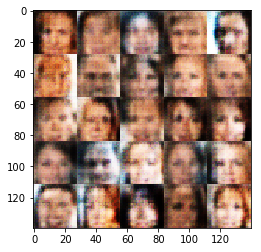

Epoch 1/2... Discriminator Loss: 1.3387... Generator Loss: 0.9833
Epoch 1/2... Discriminator Loss: 1.3575... Generator Loss: 0.8364
Epoch 1/2... Discriminator Loss: 1.3867... Generator Loss: 0.7485


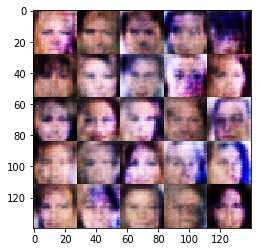

Epoch 1/2... Discriminator Loss: 1.1628... Generator Loss: 1.0553
Epoch 1/2... Discriminator Loss: 1.2785... Generator Loss: 0.9933
Epoch 1/2... Discriminator Loss: 1.3492... Generator Loss: 0.7828
Epoch 1/2... Discriminator Loss: 1.3886... Generator Loss: 1.1388


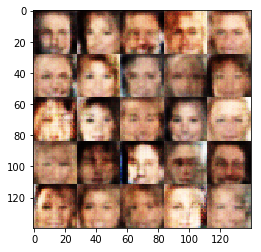

Epoch 1/2... Discriminator Loss: 1.2828... Generator Loss: 0.8270
Epoch 1/2... Discriminator Loss: 1.2947... Generator Loss: 0.7380
Epoch 1/2... Discriminator Loss: 1.2149... Generator Loss: 1.0116


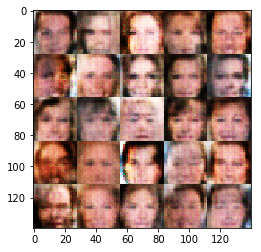

Epoch 1/2... Discriminator Loss: 1.4801... Generator Loss: 0.5199
Epoch 1/2... Discriminator Loss: 1.2960... Generator Loss: 0.8279
Epoch 1/2... Discriminator Loss: 1.2122... Generator Loss: 1.1058


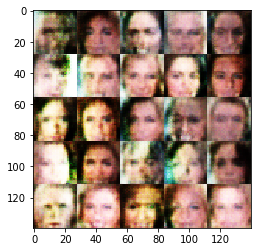

Epoch 1/2... Discriminator Loss: 1.1644... Generator Loss: 1.7395
Epoch 1/2... Discriminator Loss: 1.2409... Generator Loss: 0.8475
Epoch 1/2... Discriminator Loss: 1.1882... Generator Loss: 1.1179


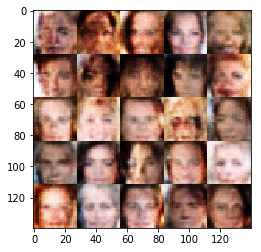

Epoch 1/2... Discriminator Loss: 1.3123... Generator Loss: 0.9884
Epoch 1/2... Discriminator Loss: 1.2268... Generator Loss: 0.6937
Epoch 1/2... Discriminator Loss: 1.3419... Generator Loss: 0.6813


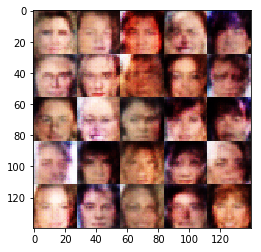

Epoch 1/2... Discriminator Loss: 0.9748... Generator Loss: 3.2307
Epoch 1/2... Discriminator Loss: 1.2505... Generator Loss: 0.8317
Epoch 1/2... Discriminator Loss: 1.1901... Generator Loss: 1.2875
Epoch 1/2... Discriminator Loss: 0.9650... Generator Loss: 1.1467


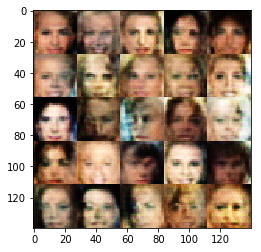

Epoch 1/2... Discriminator Loss: 1.4292... Generator Loss: 0.6527
Epoch 1/2... Discriminator Loss: 1.0445... Generator Loss: 1.8781
Epoch 1/2... Discriminator Loss: 0.9739... Generator Loss: 1.4455


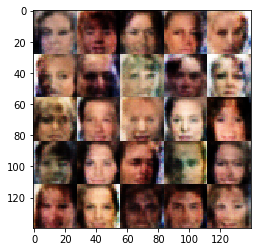

Epoch 1/2... Discriminator Loss: 1.5624... Generator Loss: 0.5888
Epoch 1/2... Discriminator Loss: 1.2555... Generator Loss: 1.1328
Epoch 1/2... Discriminator Loss: 1.4687... Generator Loss: 0.7877


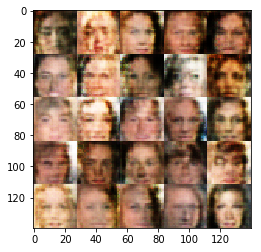

Epoch 1/2... Discriminator Loss: 1.4480... Generator Loss: 0.8049
Epoch 1/2... Discriminator Loss: 1.2494... Generator Loss: 0.9054
Epoch 1/2... Discriminator Loss: 1.3310... Generator Loss: 0.8605


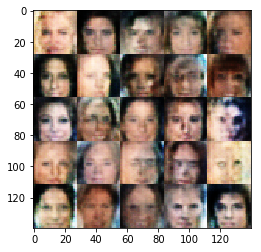

Epoch 1/2... Discriminator Loss: 1.3982... Generator Loss: 0.7145
Epoch 1/2... Discriminator Loss: 1.4503... Generator Loss: 0.7978
Epoch 1/2... Discriminator Loss: 1.3883... Generator Loss: 0.8293


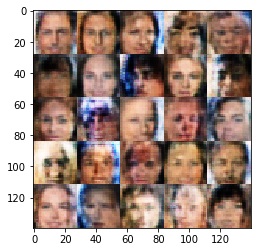

Epoch 1/2... Discriminator Loss: 1.2631... Generator Loss: 0.8940
Epoch 1/2... Discriminator Loss: 1.3663... Generator Loss: 0.7247
Epoch 1/2... Discriminator Loss: 1.3674... Generator Loss: 0.7733
Epoch 1/2... Discriminator Loss: 1.3391... Generator Loss: 0.8393


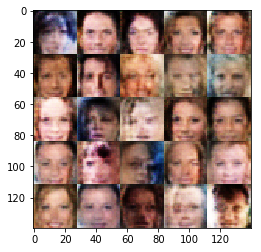

Epoch 1/2... Discriminator Loss: 1.2823... Generator Loss: 0.8817
Epoch 1/2... Discriminator Loss: 1.2227... Generator Loss: 0.9596
Epoch 1/2... Discriminator Loss: 1.3087... Generator Loss: 0.7782


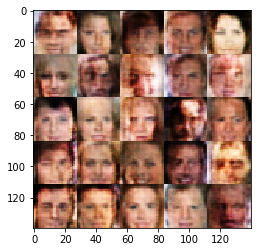

Epoch 1/2... Discriminator Loss: 1.3105... Generator Loss: 0.8191
Epoch 1/2... Discriminator Loss: 1.4238... Generator Loss: 0.8410
Epoch 1/2... Discriminator Loss: 1.3090... Generator Loss: 0.9831


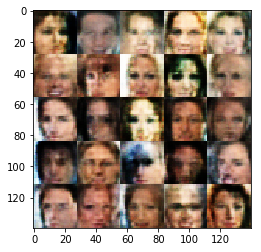

Epoch 1/2... Discriminator Loss: 1.2065... Generator Loss: 0.8552
Epoch 1/2... Discriminator Loss: 1.1584... Generator Loss: 0.8913
Epoch 1/2... Discriminator Loss: 1.3300... Generator Loss: 0.8368


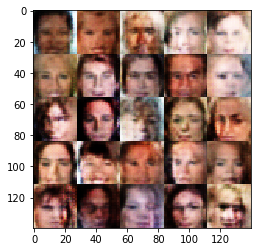

Epoch 1/2... Discriminator Loss: 1.2503... Generator Loss: 1.0017
Epoch 1/2... Discriminator Loss: 1.2610... Generator Loss: 1.0648
Epoch 1/2... Discriminator Loss: 1.1708... Generator Loss: 1.1958


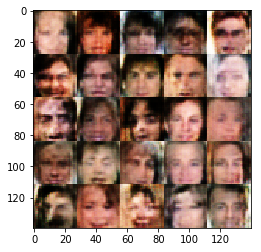

Epoch 1/2... Discriminator Loss: 1.2168... Generator Loss: 0.7605
Epoch 1/2... Discriminator Loss: 1.2659... Generator Loss: 0.9114
Epoch 1/2... Discriminator Loss: 1.2180... Generator Loss: 1.4916
Epoch 1/2... Discriminator Loss: 1.1504... Generator Loss: 1.0738


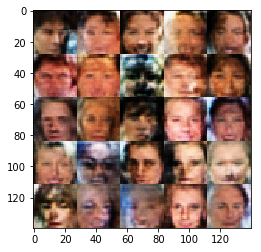

Epoch 1/2... Discriminator Loss: 1.1051... Generator Loss: 1.4234
Epoch 1/2... Discriminator Loss: 1.3883... Generator Loss: 0.6651
Epoch 1/2... Discriminator Loss: 1.3590... Generator Loss: 0.7231


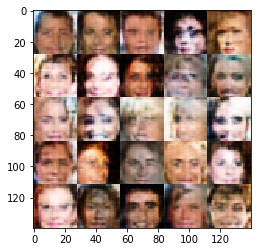

Epoch 1/2... Discriminator Loss: 1.1630... Generator Loss: 1.2826
Epoch 1/2... Discriminator Loss: 1.0772... Generator Loss: 1.0161
Epoch 1/2... Discriminator Loss: 1.1275... Generator Loss: 1.0380


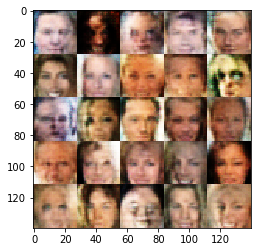

Epoch 1/2... Discriminator Loss: 1.2349... Generator Loss: 0.7513
Epoch 1/2... Discriminator Loss: 1.2359... Generator Loss: 0.7107
Epoch 1/2... Discriminator Loss: 1.1077... Generator Loss: 1.1696


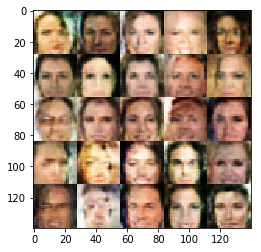

Epoch 1/2... Discriminator Loss: 1.2528... Generator Loss: 0.7931
Epoch 1/2... Discriminator Loss: 1.4203... Generator Loss: 0.9190
Epoch 1/2... Discriminator Loss: 1.2430... Generator Loss: 0.8585


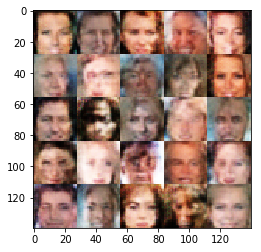

Epoch 1/2... Discriminator Loss: 1.4377... Generator Loss: 0.5848
Epoch 1/2... Discriminator Loss: 1.1534... Generator Loss: 0.8864
Epoch 1/2... Discriminator Loss: 0.9424... Generator Loss: 1.8860
Epoch 1/2... Discriminator Loss: 1.1614... Generator Loss: 0.9375


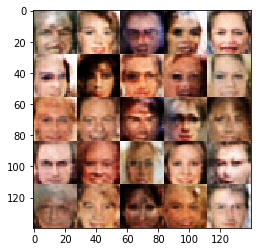

Epoch 1/2... Discriminator Loss: 1.0171... Generator Loss: 1.4235
Epoch 1/2... Discriminator Loss: 1.2256... Generator Loss: 0.8312
Epoch 1/2... Discriminator Loss: 1.1246... Generator Loss: 2.0656


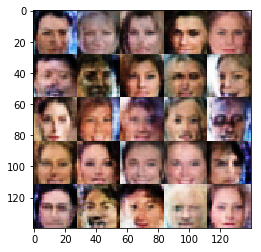

Epoch 1/2... Discriminator Loss: 1.1512... Generator Loss: 1.0631
Epoch 1/2... Discriminator Loss: 1.3857... Generator Loss: 0.6114
Epoch 1/2... Discriminator Loss: 1.2371... Generator Loss: 0.6801


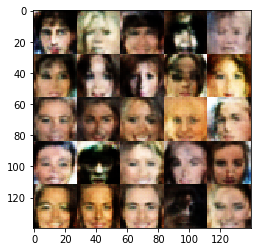

Epoch 1/2... Discriminator Loss: 1.3501... Generator Loss: 1.2122
Epoch 1/2... Discriminator Loss: 1.0650... Generator Loss: 0.9945
Epoch 1/2... Discriminator Loss: 1.1101... Generator Loss: 0.6885


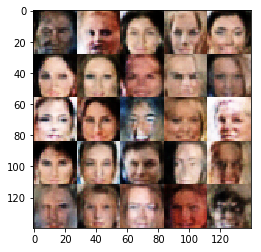

Epoch 1/2... Discriminator Loss: 0.8506... Generator Loss: 1.3987
Epoch 1/2... Discriminator Loss: 1.2771... Generator Loss: 0.5598
Epoch 1/2... Discriminator Loss: 0.9600... Generator Loss: 1.2240


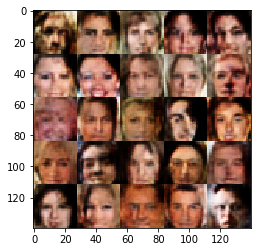

Epoch 1/2... Discriminator Loss: 0.7499... Generator Loss: 1.3575
Epoch 1/2... Discriminator Loss: 1.3317... Generator Loss: 0.5525
Epoch 1/2... Discriminator Loss: 0.6530... Generator Loss: 2.3965
Epoch 1/2... Discriminator Loss: 0.6048... Generator Loss: 1.8220


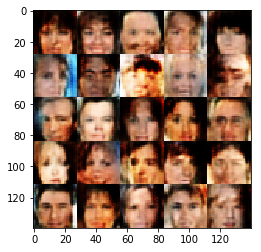

Epoch 1/2... Discriminator Loss: 0.9122... Generator Loss: 1.5646
Epoch 1/2... Discriminator Loss: 0.8625... Generator Loss: 0.9884
Epoch 1/2... Discriminator Loss: 1.0839... Generator Loss: 1.6828


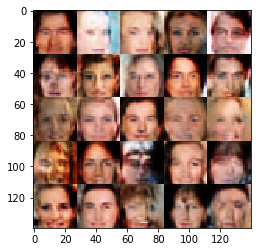

Epoch 1/2... Discriminator Loss: 0.9716... Generator Loss: 2.7771
Epoch 1/2... Discriminator Loss: 0.6100... Generator Loss: 2.3535
Epoch 1/2... Discriminator Loss: 0.6983... Generator Loss: 1.8771


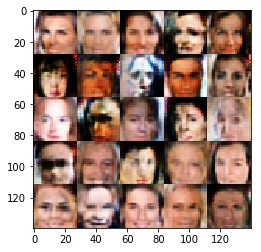

Epoch 1/2... Discriminator Loss: 0.9550... Generator Loss: 1.5576
Epoch 1/2... Discriminator Loss: 0.8353... Generator Loss: 1.9611
Epoch 1/2... Discriminator Loss: 0.9177... Generator Loss: 1.3147


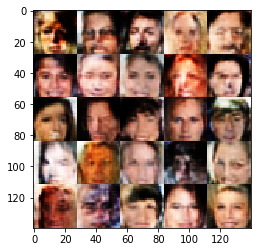

Epoch 1/2... Discriminator Loss: 1.1721... Generator Loss: 0.6630
Epoch 1/2... Discriminator Loss: 1.1532... Generator Loss: 1.8316
Epoch 1/2... Discriminator Loss: 1.2149... Generator Loss: 0.5976


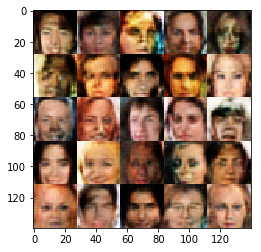

Epoch 1/2... Discriminator Loss: 0.5452... Generator Loss: 2.8858
Epoch 1/2... Discriminator Loss: 0.8526... Generator Loss: 2.0731
Epoch 1/2... Discriminator Loss: 0.9097... Generator Loss: 0.9861
Epoch 1/2... Discriminator Loss: 0.6842... Generator Loss: 1.4487


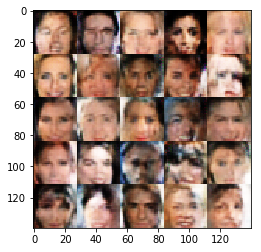

Epoch 1/2... Discriminator Loss: 0.5844... Generator Loss: 2.1942
Epoch 1/2... Discriminator Loss: 0.8707... Generator Loss: 1.0505
Epoch 1/2... Discriminator Loss: 0.8170... Generator Loss: 1.3934


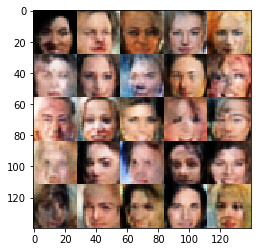

Epoch 1/2... Discriminator Loss: 0.9998... Generator Loss: 0.8721
Epoch 1/2... Discriminator Loss: 0.7500... Generator Loss: 2.3694
Epoch 1/2... Discriminator Loss: 0.6419... Generator Loss: 1.6401


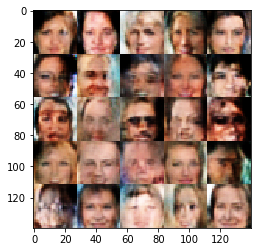

Epoch 1/2... Discriminator Loss: 0.5941... Generator Loss: 2.4431
Epoch 1/2... Discriminator Loss: 0.5534... Generator Loss: 1.9497
Epoch 1/2... Discriminator Loss: 0.6491... Generator Loss: 1.5933


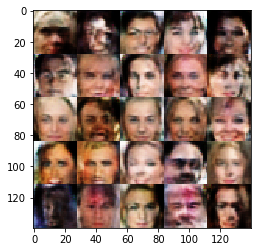

Epoch 1/2... Discriminator Loss: 0.6104... Generator Loss: 3.2131
Epoch 1/2... Discriminator Loss: 0.6084... Generator Loss: 2.5150
Epoch 1/2... Discriminator Loss: 0.7010... Generator Loss: 4.2719


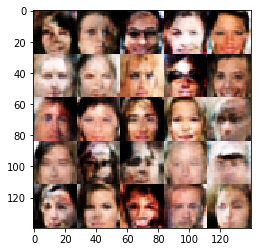

Epoch 1/2... Discriminator Loss: 0.8724... Generator Loss: 3.5027
Epoch 1/2... Discriminator Loss: 0.7631... Generator Loss: 3.4550
Epoch 1/2... Discriminator Loss: 0.9362... Generator Loss: 2.1822
Epoch 1/2... Discriminator Loss: 0.5053... Generator Loss: 2.2312


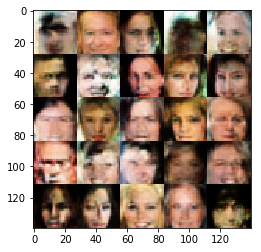

Epoch 1/2... Discriminator Loss: 0.8554... Generator Loss: 1.9617
Epoch 1/2... Discriminator Loss: 0.6622... Generator Loss: 1.5315
Epoch 1/2... Discriminator Loss: 0.6028... Generator Loss: 2.3222


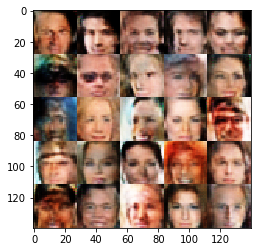

Epoch 1/2... Discriminator Loss: 0.7585... Generator Loss: 2.2824
Epoch 1/2... Discriminator Loss: 0.6961... Generator Loss: 1.3986
Epoch 1/2... Discriminator Loss: 0.6876... Generator Loss: 1.3715


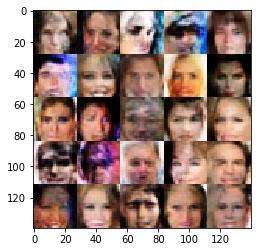

Epoch 1/2... Discriminator Loss: 0.9525... Generator Loss: 0.8684
Epoch 1/2... Discriminator Loss: 0.5620... Generator Loss: 1.9048
Epoch 1/2... Discriminator Loss: 0.4003... Generator Loss: 3.1226


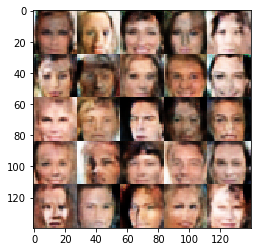

Epoch 1/2... Discriminator Loss: 0.5679... Generator Loss: 2.1459
Epoch 1/2... Discriminator Loss: 0.6373... Generator Loss: 3.3807
Epoch 1/2... Discriminator Loss: 0.7702... Generator Loss: 2.7688


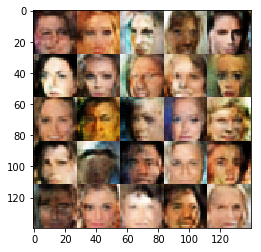

Epoch 1/2... Discriminator Loss: 1.0061... Generator Loss: 4.0831
Epoch 1/2... Discriminator Loss: 0.5567... Generator Loss: 3.2574
Epoch 2/2... Discriminator Loss: 0.8862... Generator Loss: 0.9779
Epoch 2/2... Discriminator Loss: 0.3534... Generator Loss: 4.8509


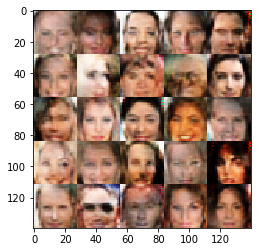

Epoch 2/2... Discriminator Loss: 0.9080... Generator Loss: 3.1118
Epoch 2/2... Discriminator Loss: 0.5349... Generator Loss: 2.6224
Epoch 2/2... Discriminator Loss: 1.2271... Generator Loss: 1.3760


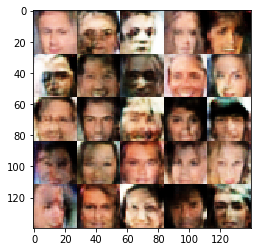

Epoch 2/2... Discriminator Loss: 0.4490... Generator Loss: 2.5883
Epoch 2/2... Discriminator Loss: 1.0149... Generator Loss: 0.8602
Epoch 2/2... Discriminator Loss: 0.7553... Generator Loss: 1.2292


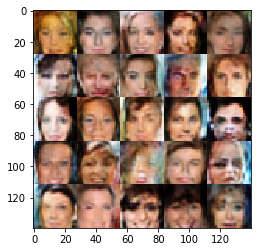

Epoch 2/2... Discriminator Loss: 0.5860... Generator Loss: 2.3373
Epoch 2/2... Discriminator Loss: 0.6826... Generator Loss: 1.6524
Epoch 2/2... Discriminator Loss: 1.1466... Generator Loss: 0.6863


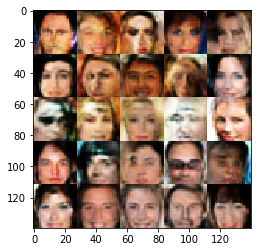

Epoch 2/2... Discriminator Loss: 0.7056... Generator Loss: 3.3982
Epoch 2/2... Discriminator Loss: 0.5735... Generator Loss: 2.3716
Epoch 2/2... Discriminator Loss: 0.5721... Generator Loss: 3.2445


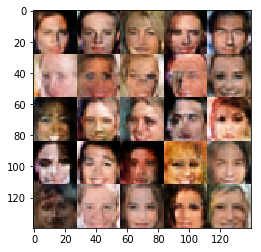

Epoch 2/2... Discriminator Loss: 0.5285... Generator Loss: 2.3799
Epoch 2/2... Discriminator Loss: 0.4213... Generator Loss: 3.0994
Epoch 2/2... Discriminator Loss: 1.9223... Generator Loss: 0.2953
Epoch 2/2... Discriminator Loss: 0.5191... Generator Loss: 2.7978


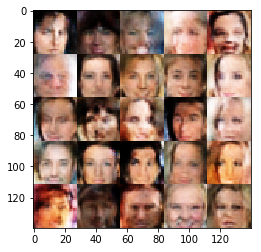

Epoch 2/2... Discriminator Loss: 0.3986... Generator Loss: 4.0406
Epoch 2/2... Discriminator Loss: 2.7921... Generator Loss: 3.0691
Epoch 2/2... Discriminator Loss: 0.6408... Generator Loss: 1.5705


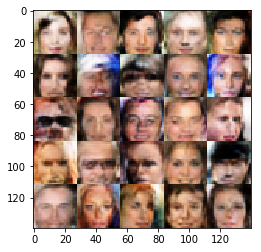

Epoch 2/2... Discriminator Loss: 0.4476... Generator Loss: 2.6633
Epoch 2/2... Discriminator Loss: 0.4188... Generator Loss: 2.9886
Epoch 2/2... Discriminator Loss: 0.8616... Generator Loss: 2.2115


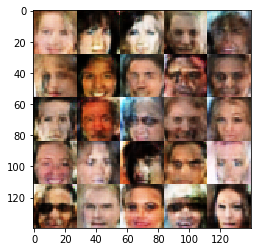

Epoch 2/2... Discriminator Loss: 0.4103... Generator Loss: 4.4270
Epoch 2/2... Discriminator Loss: 1.3913... Generator Loss: 0.5387
Epoch 2/2... Discriminator Loss: 0.9183... Generator Loss: 3.4380


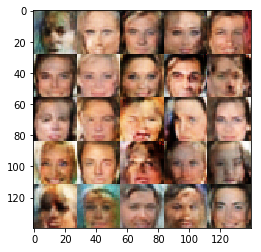

Epoch 2/2... Discriminator Loss: 0.6953... Generator Loss: 1.3641
Epoch 2/2... Discriminator Loss: 0.4049... Generator Loss: 3.2739
Epoch 2/2... Discriminator Loss: 1.1008... Generator Loss: 0.7236


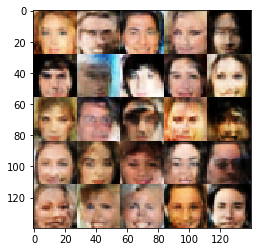

Epoch 2/2... Discriminator Loss: 0.6314... Generator Loss: 1.8971
Epoch 2/2... Discriminator Loss: 0.5585... Generator Loss: 2.1238
Epoch 2/2... Discriminator Loss: 0.5941... Generator Loss: 1.6556
Epoch 2/2... Discriminator Loss: 1.1275... Generator Loss: 2.6976


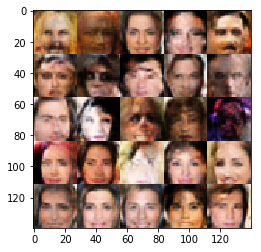

Epoch 2/2... Discriminator Loss: 0.4976... Generator Loss: 2.3472
Epoch 2/2... Discriminator Loss: 0.6199... Generator Loss: 1.5951
Epoch 2/2... Discriminator Loss: 1.0076... Generator Loss: 2.4976


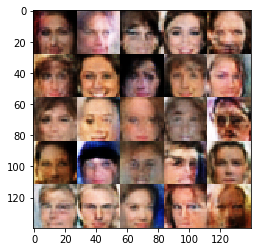

Epoch 2/2... Discriminator Loss: 0.5829... Generator Loss: 3.0959
Epoch 2/2... Discriminator Loss: 0.5877... Generator Loss: 2.1681
Epoch 2/2... Discriminator Loss: 0.5843... Generator Loss: 1.7140


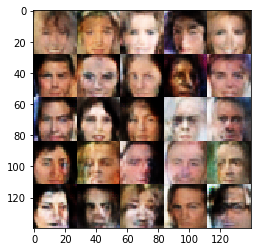

Epoch 2/2... Discriminator Loss: 0.6651... Generator Loss: 3.0273
Epoch 2/2... Discriminator Loss: 0.5341... Generator Loss: 2.1870
Epoch 2/2... Discriminator Loss: 0.6080... Generator Loss: 1.7849


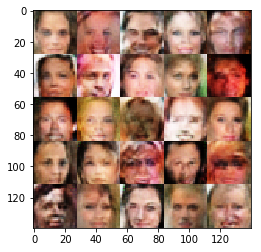

Epoch 2/2... Discriminator Loss: 0.5447... Generator Loss: 1.9567
Epoch 2/2... Discriminator Loss: 1.0376... Generator Loss: 0.7890
Epoch 2/2... Discriminator Loss: 0.5414... Generator Loss: 2.8340


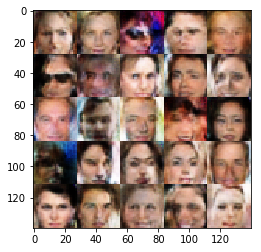

Epoch 2/2... Discriminator Loss: 0.7044... Generator Loss: 1.3732
Epoch 2/2... Discriminator Loss: 0.5434... Generator Loss: 1.9643
Epoch 2/2... Discriminator Loss: 0.4375... Generator Loss: 3.4201
Epoch 2/2... Discriminator Loss: 0.8753... Generator Loss: 1.0360


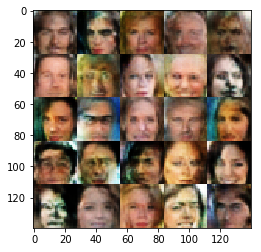

Epoch 2/2... Discriminator Loss: 0.8160... Generator Loss: 1.1581
Epoch 2/2... Discriminator Loss: 0.7996... Generator Loss: 2.9696
Epoch 2/2... Discriminator Loss: 0.4458... Generator Loss: 3.3176


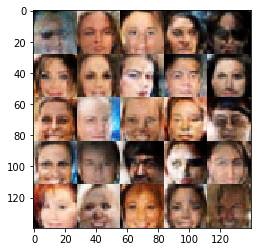

Epoch 2/2... Discriminator Loss: 0.6499... Generator Loss: 1.8194
Epoch 2/2... Discriminator Loss: 0.8807... Generator Loss: 0.9869
Epoch 2/2... Discriminator Loss: 0.4554... Generator Loss: 2.5016


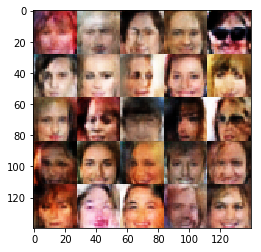

Epoch 2/2... Discriminator Loss: 0.5428... Generator Loss: 2.1056
Epoch 2/2... Discriminator Loss: 0.5539... Generator Loss: 1.9041
Epoch 2/2... Discriminator Loss: 0.7068... Generator Loss: 1.3286


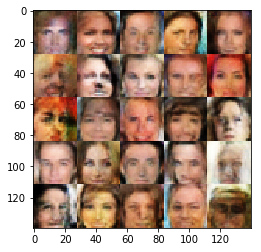

Epoch 2/2... Discriminator Loss: 0.6788... Generator Loss: 1.8447
Epoch 2/2... Discriminator Loss: 1.2582... Generator Loss: 0.6031
Epoch 2/2... Discriminator Loss: 0.5884... Generator Loss: 1.8357


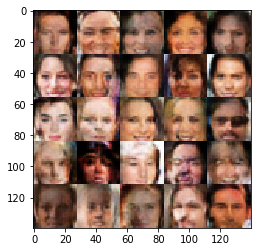

Epoch 2/2... Discriminator Loss: 0.6328... Generator Loss: 2.7312
Epoch 2/2... Discriminator Loss: 2.5407... Generator Loss: 0.1893
Epoch 2/2... Discriminator Loss: 0.5663... Generator Loss: 2.9317
Epoch 2/2... Discriminator Loss: 0.5421... Generator Loss: 2.5040


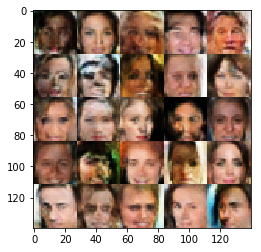

Epoch 2/2... Discriminator Loss: 0.5422... Generator Loss: 1.8820
Epoch 2/2... Discriminator Loss: 0.4420... Generator Loss: 3.4386
Epoch 2/2... Discriminator Loss: 0.4219... Generator Loss: 3.7320


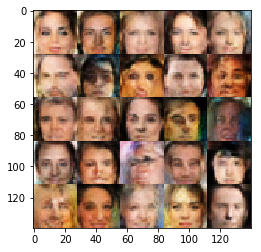

Epoch 2/2... Discriminator Loss: 0.5864... Generator Loss: 1.7692
Epoch 2/2... Discriminator Loss: 0.4920... Generator Loss: 2.4134
Epoch 2/2... Discriminator Loss: 0.4184... Generator Loss: 2.8209


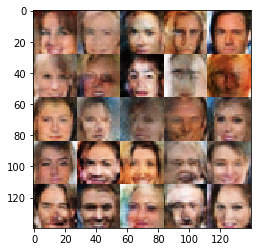

Epoch 2/2... Discriminator Loss: 0.6096... Generator Loss: 1.6829
Epoch 2/2... Discriminator Loss: 0.5098... Generator Loss: 2.2917
Epoch 2/2... Discriminator Loss: 0.7504... Generator Loss: 1.2349


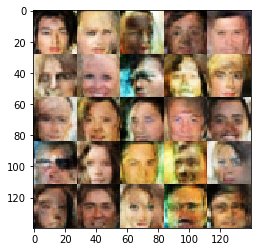

Epoch 2/2... Discriminator Loss: 0.6494... Generator Loss: 1.4745
Epoch 2/2... Discriminator Loss: 0.4594... Generator Loss: 2.6579
Epoch 2/2... Discriminator Loss: 0.6169... Generator Loss: 2.7694


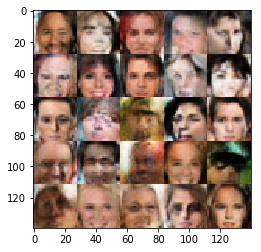

Epoch 2/2... Discriminator Loss: 0.7783... Generator Loss: 1.1820
Epoch 2/2... Discriminator Loss: 0.3893... Generator Loss: 3.9900
Epoch 2/2... Discriminator Loss: 0.4356... Generator Loss: 3.6150
Epoch 2/2... Discriminator Loss: 3.4415... Generator Loss: 5.5385


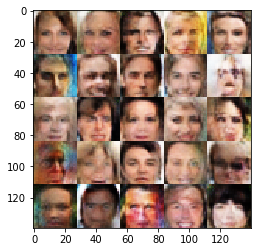

Epoch 2/2... Discriminator Loss: 0.7707... Generator Loss: 1.2848
Epoch 2/2... Discriminator Loss: 0.6257... Generator Loss: 1.5888
Epoch 2/2... Discriminator Loss: 0.4577... Generator Loss: 2.5707


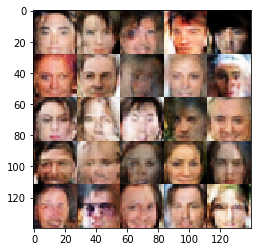

Epoch 2/2... Discriminator Loss: 0.6638... Generator Loss: 1.5771
Epoch 2/2... Discriminator Loss: 0.5142... Generator Loss: 2.3425
Epoch 2/2... Discriminator Loss: 0.5142... Generator Loss: 2.0840


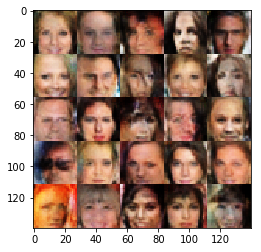

Epoch 2/2... Discriminator Loss: 0.5454... Generator Loss: 1.8720
Epoch 2/2... Discriminator Loss: 0.6634... Generator Loss: 1.6702
Epoch 2/2... Discriminator Loss: 0.7910... Generator Loss: 1.2126


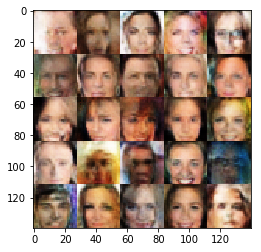

Epoch 2/2... Discriminator Loss: 0.7378... Generator Loss: 1.8218
Epoch 2/2... Discriminator Loss: 0.6016... Generator Loss: 1.6515
Epoch 2/2... Discriminator Loss: 0.7154... Generator Loss: 1.3123


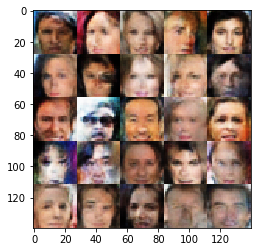

Epoch 2/2... Discriminator Loss: 1.3163... Generator Loss: 0.5705
Epoch 2/2... Discriminator Loss: 1.1397... Generator Loss: 1.4994
Epoch 2/2... Discriminator Loss: 0.7841... Generator Loss: 1.2057
Epoch 2/2... Discriminator Loss: 0.6854... Generator Loss: 1.4809


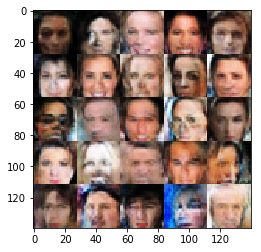

Epoch 2/2... Discriminator Loss: 0.5843... Generator Loss: 1.9137
Epoch 2/2... Discriminator Loss: 0.6234... Generator Loss: 1.6423
Epoch 2/2... Discriminator Loss: 0.5314... Generator Loss: 2.3454


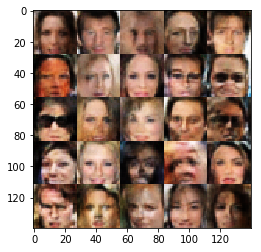

Epoch 2/2... Discriminator Loss: 0.6967... Generator Loss: 3.3647
Epoch 2/2... Discriminator Loss: 0.5623... Generator Loss: 1.8808
Epoch 2/2... Discriminator Loss: 0.5161... Generator Loss: 2.0965


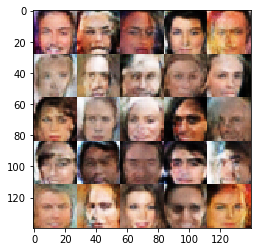

Epoch 2/2... Discriminator Loss: 0.5458... Generator Loss: 2.0007
Epoch 2/2... Discriminator Loss: 0.4842... Generator Loss: 2.6825
Epoch 2/2... Discriminator Loss: 0.5104... Generator Loss: 2.3422


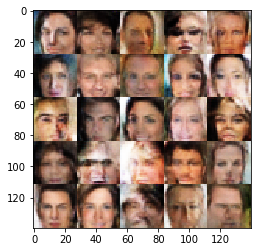

Epoch 2/2... Discriminator Loss: 0.5739... Generator Loss: 1.7758
Epoch 2/2... Discriminator Loss: 0.4389... Generator Loss: 2.7314
Epoch 2/2... Discriminator Loss: 0.6586... Generator Loss: 1.9195


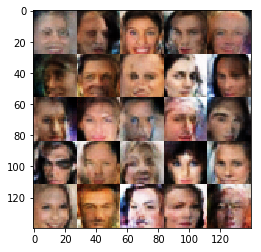

Epoch 2/2... Discriminator Loss: 0.5682... Generator Loss: 1.8086
Epoch 2/2... Discriminator Loss: 0.5222... Generator Loss: 2.0161
Epoch 2/2... Discriminator Loss: 0.5905... Generator Loss: 2.1175
Epoch 2/2... Discriminator Loss: 0.4638... Generator Loss: 2.7422


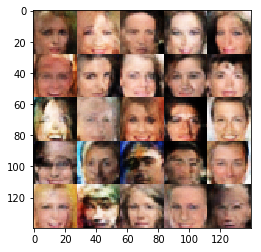

Epoch 2/2... Discriminator Loss: 0.6853... Generator Loss: 1.7982
Epoch 2/2... Discriminator Loss: 0.4923... Generator Loss: 2.1544
Epoch 2/2... Discriminator Loss: 0.4716... Generator Loss: 2.6043


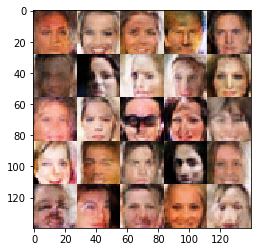

Epoch 2/2... Discriminator Loss: 1.4670... Generator Loss: 0.5146
Epoch 2/2... Discriminator Loss: 0.4900... Generator Loss: 2.3277
Epoch 2/2... Discriminator Loss: 0.4930... Generator Loss: 2.4136


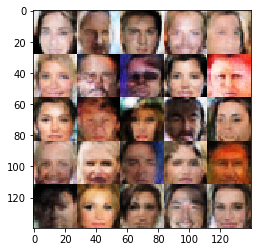

Epoch 2/2... Discriminator Loss: 0.5666... Generator Loss: 1.9577
Epoch 2/2... Discriminator Loss: 0.6000... Generator Loss: 1.7296
Epoch 2/2... Discriminator Loss: 0.8795... Generator Loss: 1.0184


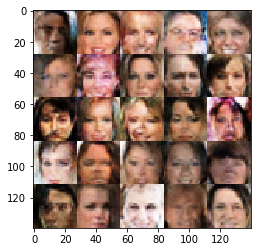

Epoch 2/2... Discriminator Loss: 0.5497... Generator Loss: 2.0445
Epoch 2/2... Discriminator Loss: 0.5309... Generator Loss: 2.1193
Epoch 2/2... Discriminator Loss: 0.4601... Generator Loss: 2.7919


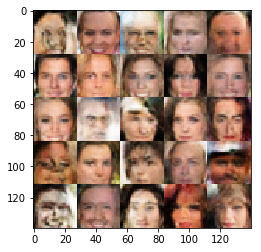

Epoch 2/2... Discriminator Loss: 0.5907... Generator Loss: 1.8326
Epoch 2/2... Discriminator Loss: 0.5189... Generator Loss: 2.7342
Epoch 2/2... Discriminator Loss: 0.7279... Generator Loss: 1.2993
Epoch 2/2... Discriminator Loss: 0.5037... Generator Loss: 3.2533


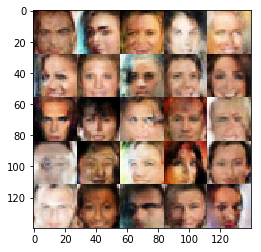

Epoch 2/2... Discriminator Loss: 0.9364... Generator Loss: 1.3369
Epoch 2/2... Discriminator Loss: 0.5732... Generator Loss: 2.9085
Epoch 2/2... Discriminator Loss: 0.4568... Generator Loss: 3.4192


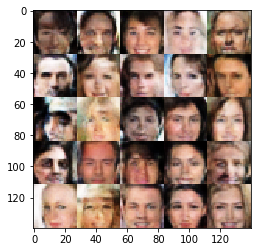

Epoch 2/2... Discriminator Loss: 0.4978... Generator Loss: 2.2795
Epoch 2/2... Discriminator Loss: 0.8381... Generator Loss: 1.7267
Epoch 2/2... Discriminator Loss: 0.8894... Generator Loss: 1.0408


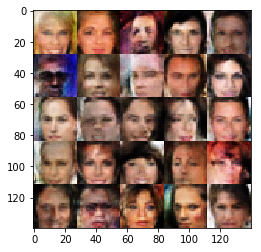

Epoch 2/2... Discriminator Loss: 0.5214... Generator Loss: 2.2166
Epoch 2/2... Discriminator Loss: 0.8025... Generator Loss: 1.1351
Epoch 2/2... Discriminator Loss: 0.5050... Generator Loss: 3.3185


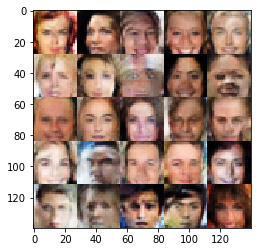

Epoch 2/2... Discriminator Loss: 0.8383... Generator Loss: 1.1342
Epoch 2/2... Discriminator Loss: 0.5747... Generator Loss: 1.8073
Epoch 2/2... Discriminator Loss: 0.5440... Generator Loss: 1.9472


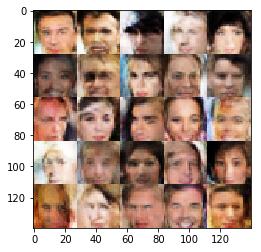

Epoch 2/2... Discriminator Loss: 1.5248... Generator Loss: 0.5084
Epoch 2/2... Discriminator Loss: 0.5087... Generator Loss: 2.2463
Epoch 2/2... Discriminator Loss: 0.7241... Generator Loss: 2.4831
Epoch 2/2... Discriminator Loss: 0.5054... Generator Loss: 2.0502


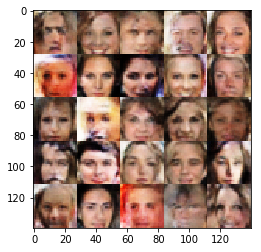

Epoch 2/2... Discriminator Loss: 0.4389... Generator Loss: 2.6498
Epoch 2/2... Discriminator Loss: 0.4716... Generator Loss: 2.3262
Epoch 2/2... Discriminator Loss: 0.5875... Generator Loss: 1.7327


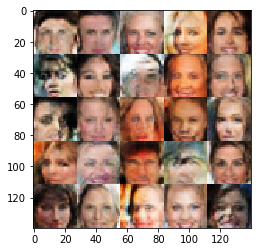

Epoch 2/2... Discriminator Loss: 0.4828... Generator Loss: 2.3504
Epoch 2/2... Discriminator Loss: 0.6168... Generator Loss: 1.5745
Epoch 2/2... Discriminator Loss: 0.8958... Generator Loss: 1.9074


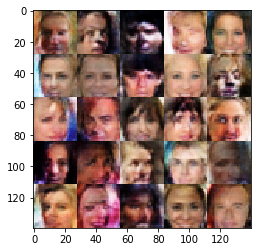

Epoch 2/2... Discriminator Loss: 0.7665... Generator Loss: 1.4320
Epoch 2/2... Discriminator Loss: 0.5179... Generator Loss: 2.7536
Epoch 2/2... Discriminator Loss: 0.7241... Generator Loss: 1.3358


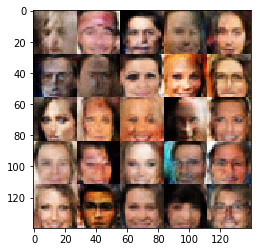

Epoch 2/2... Discriminator Loss: 0.6177... Generator Loss: 1.5589
Epoch 2/2... Discriminator Loss: 1.2348... Generator Loss: 0.6688
Epoch 2/2... Discriminator Loss: 0.4345... Generator Loss: 2.7643


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.